## CNN Classifier Testscript - Vacation Images


### Imports

In [1]:
#general
import numpy as np
import splitfolders
import time
from datetime import datetime 
from time import gmtime, strftime
from tqdm import tqdm
import os

#pytorch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

#visualization
import matplotlib.pyplot as plt

### Some parameters to be set

In [2]:
#==============#
pixel = 32    # --> 128,64,32 are valid
#==============#
version = f'{pixel}x{pixel}'
#==============#
batch_size = 8
#==============#
epochs = 200
#==============#
lr = 0.001
#==============#
momentum = 0.9
#==============#
num_workers = 4
#==============#

### Script Runtime Start

In [3]:
def start_time_():    
    start_time = time.time()
    return(start_time)

def end_time_():
    end_time = time.time()
    return(end_time)

def Execution_time(start_time_,end_time_):
    return(strftime("%H:%M:%S",gmtime(int('{:.0f}'.format(float(str((end_time_-start_time_))))))))

In [4]:
script_start = start_time_()

### Create Directory for saving files

In [5]:
dirName_1 = f'graphs/{version}'
dirName_2 = f'models/{version}'
dirName_3 = f'output_txt/{version}'

directories = [dirName_1, dirName_2, dirName_3]

# Create target Directory if don't exist

for path in directories:
    if not os.path.exists(path):
        os.mkdir(path)
        print("Directory " , path ,  " Created ")
    else:    
        print("Directory " , path ,  " already exists")  

Directory  graphs/32x32  already exists
Directory  models/32x32  already exists
Directory  output_txt/32x32  already exists


### Initialize textfile for prints

In [6]:
f = open(f'output_txt/{version}/cnn_net_b{batch_size}_e{epochs}.txt', 'a')

print(f'The parameters for this network are: \n\
        - input image size: \t {version}\n\
        - batch_size dataloader: {batch_size}\n\
        - number of epcohs: \t {epochs}\n\
        - learning rate: \t\t {lr}\n\
        - momentum: \t\t\t {momentum}\n\
        - number of workers: \t {num_workers}','\n', file=f)


### Initialize GPU

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Creating Folder Structure

The original folder containing the 2 subclass folder has to be split into subfolders for train, validation and test.

`Original:`  
* Data
    * Person
    * Scene
---
`New:`
* Data
    * train (70% of total)
        * Person
        * Scene
    * val (10% of total)
        * Person
        * Scene
    * test (20% of total)
        * Person
        * Scene

In [8]:
## Following Code does the described above

# input_folder = 'Data/'
# output_folder = 'img_data/'

# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.7, 0.1, 0.2))

In [9]:
#paths to be used for dataloaders later on
path_to_train = './img_data/train/'
path_to_val = './img_data/val/'
path_to_test = './img_data/test/'

### Define data tranformations

In [10]:
mean = [0.4939, 0.5189, 0.5326] #calculated in seperate notebook file
std = [0.2264, 0.2398, 0.2707] #calculated in seperate notebook file


#for training a litte augmentation (random flip, grayscale and rotation) will be performed
train_transforms = T.Compose([
    T.Resize([pixel,]),
    T.CenterCrop([pixel,]),
    T.RandomHorizontalFlip(0.3), 
    T.RandomGrayscale(0.1),
    T.RandomRotation(30),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
val_transforms = T.Compose([
    T.Resize([pixel,]),
    T.CenterCrop([pixel,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
test_transforms = T.Compose([
    T.Resize([pixel,]),
    T.CenterCrop([pixel,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

### Initialize Datasets (Train, Validation, Test)

In [11]:
#Create datasets, labling is done with "ImageFolder"-Method
train_dataset = torchvision.datasets.ImageFolder(root=path_to_train, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=path_to_val, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=path_to_test, transform=test_transforms)

classes = ('person', 'scene')

### Initialize DataLoaders for the Datasets

In [12]:
#Define Loaders
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

### Unnormalize pictures for visualization later

In [13]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

### Define Image viewer

In [14]:
def imshow(img):
    de_norm = UnNormalize(mean=(0.4939, 0.5189, 0.5326), std=(0.2264, 0.2398, 0.2707))
    img = de_norm(img)      # unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Define CNN 

In [15]:
class CNN(nn.Module):
    
    def __init__(self, pixel):
        
        super(CNN, self).__init__()
        self.pixel = pixel
        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2,2)
        
        #_________128x128__________________________
        if self.pixel == 128:
            self.conv1 = nn.Conv2d(3, 6, 5) 
            self.conv2 = nn.Conv2d(6, 16, 5, padding = 1) 
            self.conv3 = nn.Conv2d(16, 16, 5)
            
            self.fc1 = nn.Linear(16 * 13 * 13, 120) #(16 channel * 13 * 13 (image size))
            
        #_________64x64____________________________
        elif self.pixel == 64:
            self.conv1 = nn.Conv2d(3, 6, 3, padding = 1) 
            self.conv2 = nn.Conv2d(6, 16, 3, padding = 1) 
            self.conv3 = nn.Conv2d(16, 16, 3)
            
            self.fc1 = nn.Linear(16 * 7 * 7, 120) #(16 channel * 7 * 7 (image size))
            
        #_________32x32____________________________
        elif self.pixel == 32:
            self.conv1 = nn.Conv2d(3, 6, 3, padding = 1) 
            self.conv2 = nn.Conv2d(6, 16, 3, padding = 1) 
            self.conv3 = nn.Conv2d(16, 16, 3)
            
            self.fc1 = nn.Linear(16 * 3 * 3, 120) #(16 channel * 3 * 3 (image size))
            
        #________following_linear_layers___________
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 2)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [16]:
cnn = CNN(pixel).to(device)

### Define loss function and optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=lr, momentum=momentum)

### Train network

In [18]:
#splitted from below, to run more epochs if needed without setting loss lists to zero
train_loss = []  
validation_loss = []
min_valid_loss = np.inf  #value to distinguish if model will be saved or not. If val loss lower, model will be saved

In [19]:
#Starting Time 
train_start = start_time_()


#Training Iterations
#==========================================================================
for epoch in range(epochs):  # loop over the dataset multiple times
    
    
    #model training
    #______________________________________________________
    running_loss = 0.0
    cnn.train()
    for data, labels in tqdm(train_loader, leave=False):
        data, labels = data.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*data.size(0)
    
    
    #model validation
    #______________________________________________________
    valid_loss = 0.0
    val_correct = 0
    cnn.eval()
    for data, labels in tqdm(val_loader, leave=False):
        data, labels = data.to(device), labels.to(device)
        
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()*data.size(0)
        
        # get val_accuracy every epoch
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()
    
    
    #metrics
    #______________________________________________________
    train_loss.append(running_loss / len(train_dataset))
    validation_loss.append(valid_loss / len(val_dataset))
    val_accuracy = int(100 * val_correct / len(val_dataset))

    
    #console output for tracking
    #______________________________________________________
    console = f'Epoch {epoch+1} \t Training Loss: {(running_loss / len(train_dataset)):.6f} \t Validation Loss: {(valid_loss / len(val_dataset)):.6f} \t Validation Accuracy: {val_accuracy}%'
    print(console,file=f)
    print(console)
     
    if min_valid_loss > (valid_loss / len(val_dataset)):
        saved = f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss / len(val_dataset)):.6f}) \t Saving The Model'
        print(saved, file=f)
        print(saved)
        min_valid_loss = (valid_loss / len(val_dataset))
         
        # Saving State Dict
        torch.save(cnn.state_dict(), f'models/{version}/cnn_net_b{batch_size}_e{epochs}.pth') 
        
        
#==========================================================================


print('Finished Training','\n', file=f)
print('Finished Training')

#End Time of Training
train_end = end_time_()

#Time needed for training
print("Execution time of training:", Execution_time(train_start, train_end),'\n', file=f)
print("Execution time of training:", Execution_time(train_start, train_end))

  0%|                                                                                          | 0/261 [00:00<?, ?it/s]c:\users\matze\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 1 	 Training Loss: 0.686879 	 Validation Loss: 0.675719 	 Validation Accuracy: 59%
Validation Loss Decreased(inf--->0.675719) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 2 	 Training Loss: 0.673544 	 Validation Loss: 0.670917 	 Validation Accuracy: 59%
Validation Loss Decreased(0.675719--->0.670917) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 3 	 Training Loss: 0.668393 	 Validation Loss: 0.663268 	 Validation Accuracy: 59%
Validation Loss Decreased(0.670917--->0.663268) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 4 	 Training Loss: 0.659780 	 Validation Loss: 0.648219 	 Validation Accuracy: 59%
Validation Loss Decreased(0.663268--->0.648219) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 5 	 Training Loss: 0.639038 	 Validation Loss: 0.618301 	 Validation Accuracy: 71%
Validation Loss Decreased(0.648219--->0.618301) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 6 	 Training Loss: 0.612659 	 Validation Loss: 0.598733 	 Validation Accuracy: 69%
Validation Loss Decreased(0.618301--->0.598733) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 7 	 Training Loss: 0.596331 	 Validation Loss: 0.595016 	 Validation Accuracy: 69%
Validation Loss Decreased(0.598733--->0.595016) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 8 	 Training Loss: 0.573576 	 Validation Loss: 0.575645 	 Validation Accuracy: 70%
Validation Loss Decreased(0.595016--->0.575645) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 9 	 Training Loss: 0.525919 	 Validation Loss: 0.488938 	 Validation Accuracy: 77%
Validation Loss Decreased(0.575645--->0.488938) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 10 	 Training Loss: 0.498162 	 Validation Loss: 0.471620 	 Validation Accuracy: 79%
Validation Loss Decreased(0.488938--->0.471620) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 11 	 Training Loss: 0.481124 	 Validation Loss: 0.461797 	 Validation Accuracy: 79%
Validation Loss Decreased(0.471620--->0.461797) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 12 	 Training Loss: 0.454679 	 Validation Loss: 0.439230 	 Validation Accuracy: 80%
Validation Loss Decreased(0.461797--->0.439230) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 13 	 Training Loss: 0.441102 	 Validation Loss: 0.420472 	 Validation Accuracy: 80%
Validation Loss Decreased(0.439230--->0.420472) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 14 	 Training Loss: 0.436298 	 Validation Loss: 0.441296 	 Validation Accuracy: 79%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 15 	 Training Loss: 0.421980 	 Validation Loss: 0.413004 	 Validation Accuracy: 82%
Validation Loss Decreased(0.420472--->0.413004) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 16 	 Training Loss: 0.432142 	 Validation Loss: 0.407058 	 Validation Accuracy: 83%
Validation Loss Decreased(0.413004--->0.407058) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 17 	 Training Loss: 0.408059 	 Validation Loss: 0.437144 	 Validation Accuracy: 83%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 18 	 Training Loss: 0.405817 	 Validation Loss: 0.387490 	 Validation Accuracy: 82%
Validation Loss Decreased(0.407058--->0.387490) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 19 	 Training Loss: 0.393970 	 Validation Loss: 0.486847 	 Validation Accuracy: 77%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 20 	 Training Loss: 0.401945 	 Validation Loss: 0.391825 	 Validation Accuracy: 84%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 21 	 Training Loss: 0.391836 	 Validation Loss: 0.366705 	 Validation Accuracy: 83%
Validation Loss Decreased(0.387490--->0.366705) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 22 	 Training Loss: 0.384202 	 Validation Loss: 0.356228 	 Validation Accuracy: 83%
Validation Loss Decreased(0.366705--->0.356228) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 23 	 Training Loss: 0.380244 	 Validation Loss: 0.376608 	 Validation Accuracy: 85%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 24 	 Training Loss: 0.373232 	 Validation Loss: 0.404474 	 Validation Accuracy: 80%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 25 	 Training Loss: 0.370880 	 Validation Loss: 0.341690 	 Validation Accuracy: 86%
Validation Loss Decreased(0.356228--->0.341690) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 26 	 Training Loss: 0.363308 	 Validation Loss: 0.377678 	 Validation Accuracy: 82%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 27 	 Training Loss: 0.366612 	 Validation Loss: 0.328376 	 Validation Accuracy: 87%
Validation Loss Decreased(0.341690--->0.328376) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 28 	 Training Loss: 0.354918 	 Validation Loss: 0.326563 	 Validation Accuracy: 84%
Validation Loss Decreased(0.328376--->0.326563) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 29 	 Training Loss: 0.344119 	 Validation Loss: 0.328688 	 Validation Accuracy: 85%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 30 	 Training Loss: 0.351598 	 Validation Loss: 0.345527 	 Validation Accuracy: 84%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 31 	 Training Loss: 0.347707 	 Validation Loss: 0.322718 	 Validation Accuracy: 87%
Validation Loss Decreased(0.326563--->0.322718) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 32 	 Training Loss: 0.347857 	 Validation Loss: 0.323934 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 33 	 Training Loss: 0.335847 	 Validation Loss: 0.321312 	 Validation Accuracy: 85%
Validation Loss Decreased(0.322718--->0.321312) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 34 	 Training Loss: 0.338728 	 Validation Loss: 0.313472 	 Validation Accuracy: 86%
Validation Loss Decreased(0.321312--->0.313472) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 35 	 Training Loss: 0.337166 	 Validation Loss: 0.327072 	 Validation Accuracy: 85%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 36 	 Training Loss: 0.333746 	 Validation Loss: 0.306975 	 Validation Accuracy: 88%
Validation Loss Decreased(0.313472--->0.306975) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 37 	 Training Loss: 0.344715 	 Validation Loss: 0.316227 	 Validation Accuracy: 85%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 38 	 Training Loss: 0.323239 	 Validation Loss: 0.327891 	 Validation Accuracy: 86%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 39 	 Training Loss: 0.329074 	 Validation Loss: 0.309545 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 40 	 Training Loss: 0.324833 	 Validation Loss: 0.303791 	 Validation Accuracy: 88%
Validation Loss Decreased(0.306975--->0.303791) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 41 	 Training Loss: 0.331513 	 Validation Loss: 0.306388 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 42 	 Training Loss: 0.326467 	 Validation Loss: 0.295154 	 Validation Accuracy: 89%
Validation Loss Decreased(0.303791--->0.295154) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 43 	 Training Loss: 0.313777 	 Validation Loss: 0.311360 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 44 	 Training Loss: 0.316027 	 Validation Loss: 0.303954 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 45 	 Training Loss: 0.311768 	 Validation Loss: 0.294576 	 Validation Accuracy: 87%
Validation Loss Decreased(0.295154--->0.294576) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 46 	 Training Loss: 0.297171 	 Validation Loss: 0.316659 	 Validation Accuracy: 86%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 47 	 Training Loss: 0.309395 	 Validation Loss: 0.293764 	 Validation Accuracy: 89%
Validation Loss Decreased(0.294576--->0.293764) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 48 	 Training Loss: 0.313353 	 Validation Loss: 0.297453 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 49 	 Training Loss: 0.320160 	 Validation Loss: 0.383172 	 Validation Accuracy: 83%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 50 	 Training Loss: 0.310164 	 Validation Loss: 0.301564 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 51 	 Training Loss: 0.310716 	 Validation Loss: 0.294130 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 52 	 Training Loss: 0.311033 	 Validation Loss: 0.282313 	 Validation Accuracy: 87%
Validation Loss Decreased(0.293764--->0.282313) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 53 	 Training Loss: 0.306470 	 Validation Loss: 0.291632 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 54 	 Training Loss: 0.310317 	 Validation Loss: 0.297074 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 55 	 Training Loss: 0.293564 	 Validation Loss: 0.288492 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 56 	 Training Loss: 0.291406 	 Validation Loss: 0.295477 	 Validation Accuracy: 86%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 57 	 Training Loss: 0.294859 	 Validation Loss: 0.295363 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 58 	 Training Loss: 0.295952 	 Validation Loss: 0.313785 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 59 	 Training Loss: 0.293918 	 Validation Loss: 0.299823 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 60 	 Training Loss: 0.288733 	 Validation Loss: 0.288160 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 61 	 Training Loss: 0.294802 	 Validation Loss: 0.297913 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 62 	 Training Loss: 0.277504 	 Validation Loss: 0.365094 	 Validation Accuracy: 82%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 63 	 Training Loss: 0.292380 	 Validation Loss: 0.306937 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 64 	 Training Loss: 0.298589 	 Validation Loss: 0.280738 	 Validation Accuracy: 90%
Validation Loss Decreased(0.282313--->0.280738) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 65 	 Training Loss: 0.280530 	 Validation Loss: 0.289527 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 66 	 Training Loss: 0.294262 	 Validation Loss: 0.295176 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 67 	 Training Loss: 0.274428 	 Validation Loss: 0.292284 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 68 	 Training Loss: 0.290998 	 Validation Loss: 0.279921 	 Validation Accuracy: 88%
Validation Loss Decreased(0.280738--->0.279921) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 69 	 Training Loss: 0.275346 	 Validation Loss: 0.297445 	 Validation Accuracy: 86%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 70 	 Training Loss: 0.281665 	 Validation Loss: 0.303595 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 71 	 Training Loss: 0.268119 	 Validation Loss: 0.304849 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 72 	 Training Loss: 0.270716 	 Validation Loss: 0.271157 	 Validation Accuracy: 88%
Validation Loss Decreased(0.279921--->0.271157) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 73 	 Training Loss: 0.271160 	 Validation Loss: 0.279083 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 74 	 Training Loss: 0.281064 	 Validation Loss: 0.283201 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 75 	 Training Loss: 0.264041 	 Validation Loss: 0.278531 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 76 	 Training Loss: 0.266129 	 Validation Loss: 0.280209 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 77 	 Training Loss: 0.251060 	 Validation Loss: 0.332724 	 Validation Accuracy: 86%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 78 	 Training Loss: 0.267152 	 Validation Loss: 0.302612 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 79 	 Training Loss: 0.256656 	 Validation Loss: 0.276729 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 80 	 Training Loss: 0.266794 	 Validation Loss: 0.301992 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 81 	 Training Loss: 0.262296 	 Validation Loss: 0.318182 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 82 	 Training Loss: 0.262787 	 Validation Loss: 0.274387 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 83 	 Training Loss: 0.263971 	 Validation Loss: 0.291536 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 84 	 Training Loss: 0.252806 	 Validation Loss: 0.319084 	 Validation Accuracy: 86%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 85 	 Training Loss: 0.254206 	 Validation Loss: 0.300824 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 86 	 Training Loss: 0.259841 	 Validation Loss: 0.277748 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 87 	 Training Loss: 0.243989 	 Validation Loss: 0.282842 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 88 	 Training Loss: 0.242176 	 Validation Loss: 0.293916 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 89 	 Training Loss: 0.257808 	 Validation Loss: 0.291654 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 90 	 Training Loss: 0.239666 	 Validation Loss: 0.286223 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 91 	 Training Loss: 0.242562 	 Validation Loss: 0.306020 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 92 	 Training Loss: 0.243024 	 Validation Loss: 0.282083 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 93 	 Training Loss: 0.257332 	 Validation Loss: 0.276380 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 94 	 Training Loss: 0.239160 	 Validation Loss: 0.299533 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 95 	 Training Loss: 0.233697 	 Validation Loss: 0.311535 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 96 	 Training Loss: 0.256812 	 Validation Loss: 0.269771 	 Validation Accuracy: 89%
Validation Loss Decreased(0.271157--->0.269771) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 97 	 Training Loss: 0.238786 	 Validation Loss: 0.254333 	 Validation Accuracy: 90%
Validation Loss Decreased(0.269771--->0.254333) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 98 	 Training Loss: 0.248454 	 Validation Loss: 0.270091 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 99 	 Training Loss: 0.219629 	 Validation Loss: 0.273256 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 100 	 Training Loss: 0.216055 	 Validation Loss: 0.287904 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 101 	 Training Loss: 0.241481 	 Validation Loss: 0.286751 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 102 	 Training Loss: 0.234885 	 Validation Loss: 0.284131 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 103 	 Training Loss: 0.230567 	 Validation Loss: 0.270905 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 104 	 Training Loss: 0.243995 	 Validation Loss: 0.271518 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 105 	 Training Loss: 0.230483 	 Validation Loss: 0.289167 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 106 	 Training Loss: 0.221215 	 Validation Loss: 0.289910 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 107 	 Training Loss: 0.235374 	 Validation Loss: 0.287915 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 108 	 Training Loss: 0.234083 	 Validation Loss: 0.285755 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 109 	 Training Loss: 0.233538 	 Validation Loss: 0.258432 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 110 	 Training Loss: 0.226108 	 Validation Loss: 0.314004 	 Validation Accuracy: 86%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 111 	 Training Loss: 0.233075 	 Validation Loss: 0.271401 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 112 	 Training Loss: 0.231397 	 Validation Loss: 0.270362 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 113 	 Training Loss: 0.238265 	 Validation Loss: 0.294407 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 114 	 Training Loss: 0.226945 	 Validation Loss: 0.272497 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 115 	 Training Loss: 0.228191 	 Validation Loss: 0.264308 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 116 	 Training Loss: 0.231563 	 Validation Loss: 0.263361 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 117 	 Training Loss: 0.213122 	 Validation Loss: 0.274849 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 118 	 Training Loss: 0.210374 	 Validation Loss: 0.290970 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 119 	 Training Loss: 0.223768 	 Validation Loss: 0.268027 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 120 	 Training Loss: 0.212987 	 Validation Loss: 0.294529 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 121 	 Training Loss: 0.214815 	 Validation Loss: 0.260360 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 122 	 Training Loss: 0.224882 	 Validation Loss: 0.268451 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 123 	 Training Loss: 0.207147 	 Validation Loss: 0.300266 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 124 	 Training Loss: 0.225103 	 Validation Loss: 0.264175 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 125 	 Training Loss: 0.200228 	 Validation Loss: 0.291830 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 126 	 Training Loss: 0.215148 	 Validation Loss: 0.258810 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 127 	 Training Loss: 0.222769 	 Validation Loss: 0.278142 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 128 	 Training Loss: 0.202165 	 Validation Loss: 0.331120 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 129 	 Training Loss: 0.208635 	 Validation Loss: 0.256567 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 130 	 Training Loss: 0.214590 	 Validation Loss: 0.290752 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 131 	 Training Loss: 0.208781 	 Validation Loss: 0.272428 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 132 	 Training Loss: 0.221701 	 Validation Loss: 0.277987 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 133 	 Training Loss: 0.212530 	 Validation Loss: 0.289996 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 134 	 Training Loss: 0.217316 	 Validation Loss: 0.295502 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 135 	 Training Loss: 0.211343 	 Validation Loss: 0.255082 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 136 	 Training Loss: 0.192500 	 Validation Loss: 0.284448 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 137 	 Training Loss: 0.212412 	 Validation Loss: 0.290111 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 138 	 Training Loss: 0.199711 	 Validation Loss: 0.297696 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 139 	 Training Loss: 0.200552 	 Validation Loss: 0.307160 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 140 	 Training Loss: 0.201613 	 Validation Loss: 0.297869 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 141 	 Training Loss: 0.197085 	 Validation Loss: 0.266964 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 142 	 Training Loss: 0.204428 	 Validation Loss: 0.268401 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 143 	 Training Loss: 0.201871 	 Validation Loss: 0.286854 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 144 	 Training Loss: 0.194745 	 Validation Loss: 0.274064 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 145 	 Training Loss: 0.215996 	 Validation Loss: 0.297959 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 146 	 Training Loss: 0.215870 	 Validation Loss: 0.271486 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 147 	 Training Loss: 0.197711 	 Validation Loss: 0.273454 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 148 	 Training Loss: 0.195796 	 Validation Loss: 0.300969 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 149 	 Training Loss: 0.208506 	 Validation Loss: 0.324271 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 150 	 Training Loss: 0.207853 	 Validation Loss: 0.277080 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 151 	 Training Loss: 0.200370 	 Validation Loss: 0.271463 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 152 	 Training Loss: 0.178254 	 Validation Loss: 0.270945 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 153 	 Training Loss: 0.219030 	 Validation Loss: 0.237528 	 Validation Accuracy: 91%
Validation Loss Decreased(0.254333--->0.237528) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 154 	 Training Loss: 0.202261 	 Validation Loss: 0.283731 	 Validation Accuracy: 88%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 155 	 Training Loss: 0.194519 	 Validation Loss: 0.290885 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 156 	 Training Loss: 0.205071 	 Validation Loss: 0.351148 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 157 	 Training Loss: 0.201136 	 Validation Loss: 0.285094 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 158 	 Training Loss: 0.191008 	 Validation Loss: 0.313710 	 Validation Accuracy: 87%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 159 	 Training Loss: 0.175309 	 Validation Loss: 0.307903 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 160 	 Training Loss: 0.201283 	 Validation Loss: 0.259851 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 161 	 Training Loss: 0.186099 	 Validation Loss: 0.265556 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 162 	 Training Loss: 0.199171 	 Validation Loss: 0.271362 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 163 	 Training Loss: 0.195536 	 Validation Loss: 0.287305 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 164 	 Training Loss: 0.190714 	 Validation Loss: 0.298283 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 165 	 Training Loss: 0.185603 	 Validation Loss: 0.291183 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 166 	 Training Loss: 0.188895 	 Validation Loss: 0.300216 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 167 	 Training Loss: 0.184430 	 Validation Loss: 0.280409 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 168 	 Training Loss: 0.170751 	 Validation Loss: 0.292232 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 169 	 Training Loss: 0.184910 	 Validation Loss: 0.299157 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 170 	 Training Loss: 0.183175 	 Validation Loss: 0.273498 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 171 	 Training Loss: 0.179225 	 Validation Loss: 0.278086 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 172 	 Training Loss: 0.188828 	 Validation Loss: 0.262125 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 173 	 Training Loss: 0.187441 	 Validation Loss: 0.271841 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 174 	 Training Loss: 0.181536 	 Validation Loss: 0.293041 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 175 	 Training Loss: 0.179333 	 Validation Loss: 0.257562 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 176 	 Training Loss: 0.185546 	 Validation Loss: 0.316096 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 177 	 Training Loss: 0.176227 	 Validation Loss: 0.263655 	 Validation Accuracy: 92%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 178 	 Training Loss: 0.185488 	 Validation Loss: 0.263050 	 Validation Accuracy: 92%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 179 	 Training Loss: 0.186539 	 Validation Loss: 0.268207 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 180 	 Training Loss: 0.184974 	 Validation Loss: 0.299954 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 181 	 Training Loss: 0.175714 	 Validation Loss: 0.292115 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 182 	 Training Loss: 0.168199 	 Validation Loss: 0.283870 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 183 	 Training Loss: 0.184708 	 Validation Loss: 0.280920 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 184 	 Training Loss: 0.174746 	 Validation Loss: 0.276454 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 185 	 Training Loss: 0.175079 	 Validation Loss: 0.294940 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 186 	 Training Loss: 0.179453 	 Validation Loss: 0.277299 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 187 	 Training Loss: 0.199100 	 Validation Loss: 0.260276 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 188 	 Training Loss: 0.159409 	 Validation Loss: 0.296202 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 189 	 Training Loss: 0.173725 	 Validation Loss: 0.265907 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 190 	 Training Loss: 0.167634 	 Validation Loss: 0.261537 	 Validation Accuracy: 92%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 191 	 Training Loss: 0.173759 	 Validation Loss: 0.265089 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 192 	 Training Loss: 0.169859 	 Validation Loss: 0.284393 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 193 	 Training Loss: 0.170268 	 Validation Loss: 0.274630 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 194 	 Training Loss: 0.165183 	 Validation Loss: 0.325531 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 195 	 Training Loss: 0.160798 	 Validation Loss: 0.301329 	 Validation Accuracy: 91%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 196 	 Training Loss: 0.173571 	 Validation Loss: 0.301390 	 Validation Accuracy: 90%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 197 	 Training Loss: 0.161407 	 Validation Loss: 0.272330 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 198 	 Training Loss: 0.163713 	 Validation Loss: 0.308503 	 Validation Accuracy: 89%


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 199 	 Training Loss: 0.175284 	 Validation Loss: 0.305718 	 Validation Accuracy: 89%


Epoch 200 	 Training Loss: 0.158621 	 Validation Loss: 0.281048 	 Validation Accuracy: 91%
Finished Training
Execution time of training: 03:49:18


### Show loss over epochs

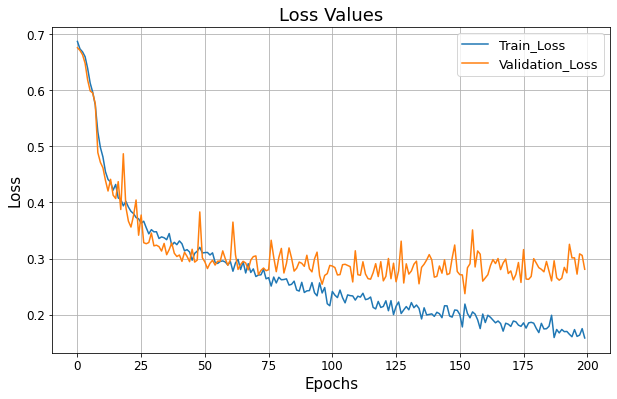

In [20]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train_Loss')
plt.plot(validation_loss, label='Validation_Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=13)
plt.tick_params(labelsize=12)
plt.grid()
plt.title('Loss Values', fontsize=18)
plt.savefig(f'graphs/{version}/loss_b{batch_size}_e{epochs}.png', dpi=300)

### Testing
#### Sample

Truth: scene 	 Prediction: scene 	 Result: Right


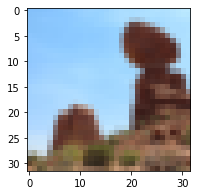

Truth: scene 	 Prediction: scene 	 Result: Right


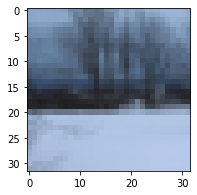

Truth: person 	 Prediction: person 	 Result: Right


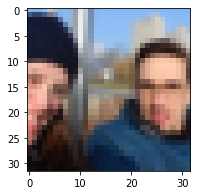

Truth: scene 	 Prediction: scene 	 Result: Right


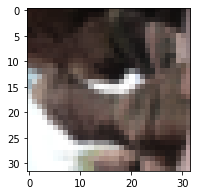

Truth: scene 	 Prediction: scene 	 Result: Right


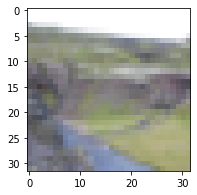

Truth: scene 	 Prediction: scene 	 Result: Right


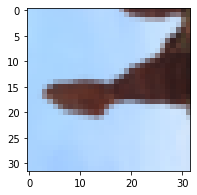

Truth: scene 	 Prediction: scene 	 Result: Right


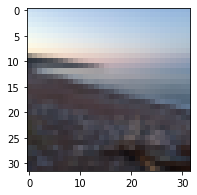

Truth: person 	 Prediction: person 	 Result: Right


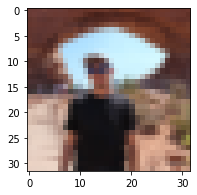

In [21]:
#load a batch from the test set
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

#generate predictions of testloader samples
#deactivate droptout layer with .eval()
cnn.eval()                 
outputs = cnn(images)

#the class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs, 1)

for i in range(batch_size):
    if classes[labels[i]] == classes[predicted[i]]:
        boolean = 'Right'
    else:
        boolean = 'Wrong'
    print(f'Truth: {classes[labels[i]]} \t Prediction: {classes[predicted[i]]} \t Result: {boolean}')
    imshow(images[i])

#### Complete testset - final epoch

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = cnn(data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 597 test images: %d %%' % (100 * correct / total),'\n', file=f)
print('Accuracy of the network on the 597 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 597 test images: 90 %


#### Complete testset - best epoch

In [23]:
#Loading the model
cnn_best = CNN(pixel).to(device)
cnn_best.load_state_dict(torch.load(f'models/{version}/cnn_net_b{batch_size}_e{epochs}.pth'))
cnn.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = cnn_best(data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = int(100 * correct / total)

print('Accuracy of the network on the 597 test images with best iteration: %d %%' % (100 * correct / total),'\n', file=f)
print('Accuracy of the network on the 597 test images with best iteration: %d %%' % (100 * correct / total))

Accuracy of the network on the 597 test images with best iteration: 88 %


### Script Runtime Result

In [24]:
#End Time of Training
script_end = end_time_()

#Time needed for script
print(f'Execution time of script is : {Execution_time(script_start, script_end)} hh:mm:ss')

Execution time of script is : 03:50:00 hh:mm:ss


### Closing output textfile

In [25]:
f.close()